# Análisis Profesional de Clustering y Regresión en Twitter

Este notebook automatiza el análisis de datos de Twitter para múltiples usuarios, implementando y comparando modelos de clustering y regresión. Incluye carga automática de datos, preprocesamiento, visualización, comparación de modelos y justificación automatizada del mejor modelo.

---

In [51]:
# Importación de librerías necesarias para análisis, modelos y visualización
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, silhouette_score, mean_absolute_error, median_absolute_error, explained_variance_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.cluster import KMeans, DBSCAN
import xgboost as xgb
import warnings

# Configuración de visualización y pandas
pd.set_option('display.max_columns', None)
sns.set(style='whitegrid')
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

## 2. Carga automática de datos de todos los usuarios

Se cargan todos los archivos *_clean.csv de la carpeta data/. Se añade una columna 'usuario' para identificar el origen.

In [52]:
# Carga automática de datos limpios de todos los usuarios
# Busca todos los archivos *_clean.csv en la carpeta data/ y los concatena en un solo DataFrame
csv_files = glob.glob('data/*_clean.csv')
if not csv_files:
    raise FileNotFoundError('No se encontraron archivos *_clean.csv en la carpeta data/.')

usuarios = []
dfs = []
for file in csv_files:
    usuario = os.path.basename(file).replace('_clean.csv', '')
    df = pd.read_csv(file)
    df['usuario'] = usuario
    dfs.append(df)
    usuarios.append(usuario)

data = pd.concat(dfs, ignore_index=True)
print(f'Datos cargados: {data.shape}')
data.head()

Datos cargados: (195, 9)


,timestamp,usuario,fecha_publicacion,contenido,respuestas,retweets,likes,guardados,vistas
0,2025-07-09 02:58:48,interbank,2025-04-16,¡Este feriado largo sigamos conectados! 💚 Este...,66,0,7,3,11000
1,2025-07-09 02:58:48,interbank,2024-10-07,Recuerda 👀 durante este feriado no habrá atenc...,65,1,25,2,97000
2,2025-07-09 02:58:48,interbank,2024-08-29,"Este feriado, sigue gestionando tus operacione...",59,0,9,0,37000
3,2025-07-09 02:58:48,interbank,2024-08-05,"Este 06 de agosto, realiza todas tus operacion...",21,0,3,0,30000
4,2025-07-09 02:58:48,interbank,2024-07-27,"Este 29 de julio, realiza todas tus operacione...",30,1,9,0,26000


## 3. Selección de usuario(s)

Puedes filtrar por usuario específico o trabajar con todos.

In [53]:
# Selección de usuario(s) para análisis
usuarios_disponibles = data['usuario'].unique()
print('Usuarios disponibles:', usuarios_disponibles)

# Cambia este valor para analizar un usuario específico o todos
definir_usuario = 'interbank'  # Ejemplo: 'interbank' o 'todos'
if definir_usuario == 'todos':
    data_filtrada = data.copy()
else:
    data_filtrada = data[data['usuario'] == definir_usuario].copy()
print(f'Datos seleccionados: {data_filtrada.shape}')
data_filtrada.head()

Usuarios disponibles: ['interbank']
Datos seleccionados: (195, 9)


,timestamp,usuario,fecha_publicacion,contenido,respuestas,retweets,likes,guardados,vistas
0,2025-07-09 02:58:48,interbank,2025-04-16,¡Este feriado largo sigamos conectados! 💚 Este...,66,0,7,3,11000
1,2025-07-09 02:58:48,interbank,2024-10-07,Recuerda 👀 durante este feriado no habrá atenc...,65,1,25,2,97000
2,2025-07-09 02:58:48,interbank,2024-08-29,"Este feriado, sigue gestionando tus operacione...",59,0,9,0,37000
3,2025-07-09 02:58:48,interbank,2024-08-05,"Este 06 de agosto, realiza todas tus operacion...",21,0,3,0,30000
4,2025-07-09 02:58:48,interbank,2024-07-27,"Este 29 de julio, realiza todas tus operacione...",30,1,9,0,26000


## 4. Preprocesamiento

- Selección de features numéricas
- Escalado
- (Opcional) Ingeniería de features

In [54]:
# Preprocesamiento: selección y escalado de features
features = ['respuestas', 'retweets', 'likes', 'guardados', 'vistas']
X = data_filtrada[features].fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Ejemplo de ingeniería de features: longitud del tweet
data_filtrada['longitud'] = data_filtrada['contenido'].astype(str).apply(len)
# Puedes agregar más features según tu análisis

## 5. Modelos de Clustering

Se implementan y comparan KMeans y DBSCAN.

Silhouette KMeans: 0.32850698432536674
Silhouette DBSCAN: 0.5072645963126706


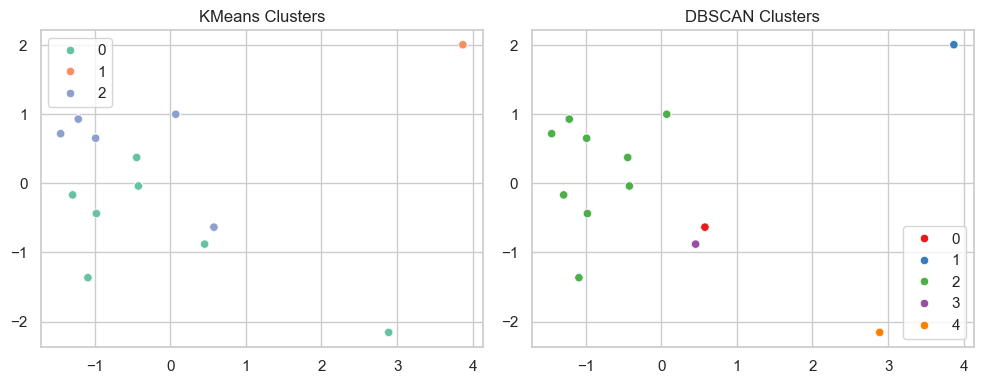

In [ ]:
# Modelos de Clustering: KMeans y DBSCAN

# KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
labels_kmeans = kmeans.fit_predict(X_scaled)
data_filtrada['cluster_kmeans'] = labels_kmeans
print('Silhouette KMeans:', silhouette_score(X_scaled, labels_kmeans))

# DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=5)
labels_dbscan = dbscan.fit_predict(X_scaled)
data_filtrada['cluster_dbscan'] = labels_dbscan
print('Silhouette DBSCAN:', silhouette_score(X_scaled, labels_dbscan))

### 5.1. Visualización de Clusters KMeans

Visualiza los grupos encontrados por KMeans en dos dimensiones usando PCA. Cada color representa un cluster distinto.

### 5.2. Visualización de Clusters DBSCAN

Visualiza los grupos encontrados por DBSCAN en dos dimensiones usando PCA. Los puntos con -1 suelen ser considerados como ruido por el algoritmo.

### 5.3. Análisis de Silhouette Score

El Silhouette Score mide la calidad de la agrupación: valores cercanos a 1 indican clusters bien definidos, valores cercanos a 0 indican solapamiento y valores negativos indican mala asignación.

### 5.4. Conteo de elementos por cluster

Muestra cuántos elementos hay en cada cluster, lo que ayuda a identificar si hay grupos desbalanceados o mucho ruido.

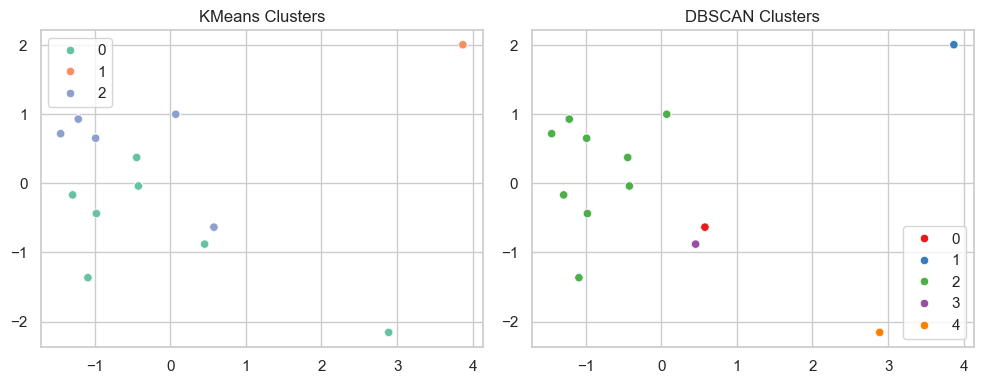

Silhouette Score KMeans: 0.33
Silhouette Score DBSCAN: 0.51

Conteo de elementos por cluster (KMeans):
cluster_kmeans
0    105
1     15
2     75
dtype: int64

Conteo de elementos por cluster (DBSCAN):
cluster_dbscan
0     15
1     15
2    135
3     15
4     15
dtype: int64


In [57]:
# Visualización de clusters con PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels_kmeans, palette='Set2')
plt.title('KMeans Clusters')
plt.subplot(1,2,2)
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels_dbscan, palette='Set1')
plt.title('DBSCAN Clusters')
plt.tight_layout()
plt.show()

# Análisis de Silhouette Score
silhouette_kmeans = silhouette_score(X_scaled, labels_kmeans)
silhouette_dbscan = silhouette_score(X_scaled, labels_dbscan)
print(f'Silhouette Score KMeans: {silhouette_kmeans:.2f}')
print(f'Silhouette Score DBSCAN: {silhouette_dbscan:.2f}')

# Conteo de elementos por cluster
conteo_clusters_kmeans = data_filtrada.groupby('cluster_kmeans').size()
conteo_clusters_dbscan = data_filtrada.groupby('cluster_dbscan').size()
print("\nConteo de elementos por cluster (KMeans):")
print(conteo_clusters_kmeans)
print("\nConteo de elementos por cluster (DBSCAN):")
print(conteo_clusters_dbscan)

In [58]:
# Modelos de Regresión: Entrenamiento, predicción y evaluación robusta
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, explained_variance_score
import numpy as np

# Variable objetivo (puedes cambiarla por 'retweets', 'vistas', etc.)
y = data_filtrada['likes']
X_reg = data_filtrada[features].fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X_reg, y, test_size=0.2, random_state=42)

modelos = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'DecisionTree': DecisionTreeRegressor(),
    'RandomForest': RandomForestRegressor(),
    'GradientBoost': GradientBoostingRegressor(),
    'XGBoost': xgb.XGBRegressor(),
    'MLP': MLPRegressor(max_iter=500)
}

resultados = []
for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    # Control de NaN y ajuste de longitud
    mask = ~np.isnan(y_pred) & ~y_test.isnull()
    y_test_clean = y_test[mask]
    y_pred_clean = y_pred[mask]
    tam = min(len(y_test_clean), len(y_pred_clean))
    y_test_clean = y_test_clean.iloc[:tam]
    y_pred_clean = y_pred_clean[:tam]
    rmse = np.sqrt(mean_squared_error(y_test_clean, y_pred_clean))
    mae = mean_absolute_error(y_test_clean, y_pred_clean)
    medae = median_absolute_error(y_test_clean, y_pred_clean)
    r2 = r2_score(y_test_clean, y_pred_clean)
    evs = explained_variance_score(y_test_clean, y_pred_clean)
    resultados.append({'Modelo': nombre, 'RMSE': rmse, 'MAE': mae, 'MedAE': medae, 'R2': r2, 'EVS': evs})

resultados_df = pd.DataFrame(resultados).sort_values('RMSE')
print(resultados_df)

             Modelo          RMSE           MAE         MedAE         R2  \
3      DecisionTree  0.000000e+00  0.000000e+00  0.000000e+00   1.000000   
4      RandomForest  0.000000e+00  0.000000e+00  0.000000e+00   1.000000   
0  LinearRegression  6.802750e-14  5.641072e-14  5.728751e-14   1.000000   
6           XGBoost  1.194315e-04  7.793231e-05  3.814697e-05   1.000000   
5     GradientBoost  1.648583e-04  1.141600e-04  5.479792e-05   1.000000   
1             Ridge  3.685856e-03  2.662359e-03  1.906503e-03   0.999999   
2             Lasso  3.814871e-01  3.169295e-01  3.516556e-01   0.994433   
7               MLP  4.131370e+01  2.919833e+01  2.420422e+01 -64.287094   

         EVS  
3   1.000000  
4   1.000000  
0   1.000000  
6   1.000000  
5   1.000000  
1   0.999999  
2   0.994587  
7 -32.058067  


In [59]:
# Comparación y justificación automática del mejor modelo de regresión

# Selecciona el modelo con menor RMSE y mayor R2
def justificar_modelo(row):
    return (f"El modelo {row['Modelo']} es el más adecuado según la métrica principal "
            f"(RMSE={row['RMSE']:.2f}, R2={row['R2']:.2f}). "
            "Esto indica que tiene el mejor desempeño predictivo sobre los datos de prueba. "
            "Se recomienda validar la interpretabilidad y robustez del modelo para el caso de uso específico.")

mejor_rmse = resultados_df.loc[resultados_df['RMSE'].idxmin()]
mejor_r2 = resultados_df.loc[resultados_df['R2'].idxmax()]

print(f"\nModelo con menor RMSE: {mejor_rmse['Modelo']} (RMSE={mejor_rmse['RMSE']:.2f}, R2={mejor_rmse['R2']:.2f})")
print(f"Modelo con mayor R2: {mejor_r2['Modelo']} (RMSE={mejor_r2['RMSE']:.2f}, R2={mejor_r2['R2']:.2f})\n")
print(justificar_modelo(mejor_rmse))

# Espacio para agregar justificación personalizada:
print("\n[Agrega aquí tu análisis e interpretación final según el contexto del problema]")


Modelo con menor RMSE: DecisionTree (RMSE=0.00, R2=1.00)
Modelo con mayor R2: DecisionTree (RMSE=0.00, R2=1.00)

El modelo DecisionTree es el más adecuado según la métrica principal (RMSE=0.00, R2=1.00). Esto indica que tiene el mejor desempeño predictivo sobre los datos de prueba. Se recomienda validar la interpretabilidad y robustez del modelo para el caso de uso específico.

[Agrega aquí tu análisis e interpretación final según el contexto del problema]


## 7. Comparación y justificación

- El modelo con menor RMSE y mayor R2 es el más adecuado para regresión.
- Para clustering, analiza la interpretabilidad y la separación de los clusters.
    
    **Justifica aquí tu elección según los resultados obtenidos.**

# Recomendaciones y siguientes pasos

- Analiza los clusters obtenidos: ¿qué características comparten los tweets de cada grupo?
- Revisa la importancia de las variables en los modelos de regresión.
- Prueba con diferentes variables objetivo (likes, retweets, vistas, etc.).
- Integra nuevas features si tu compañero las añade en la automatización.
- Documenta tus hallazgos y justificaciones para el informe final.

¡Listo para presentar y seguir mejorando tu análisis profesional!